In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image


np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import autokeras as ak

In [2]:
skin_df=pd.read_csv(r"D:\cancer\HAM10000_metadata.csv")

In [3]:
SIZE=32

# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [4]:
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extremity      5  
8984  lower extremity      5  
2310 

C:\Users\shrey\AppData\Local\Temp\ipykernel_15012\3283764244.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


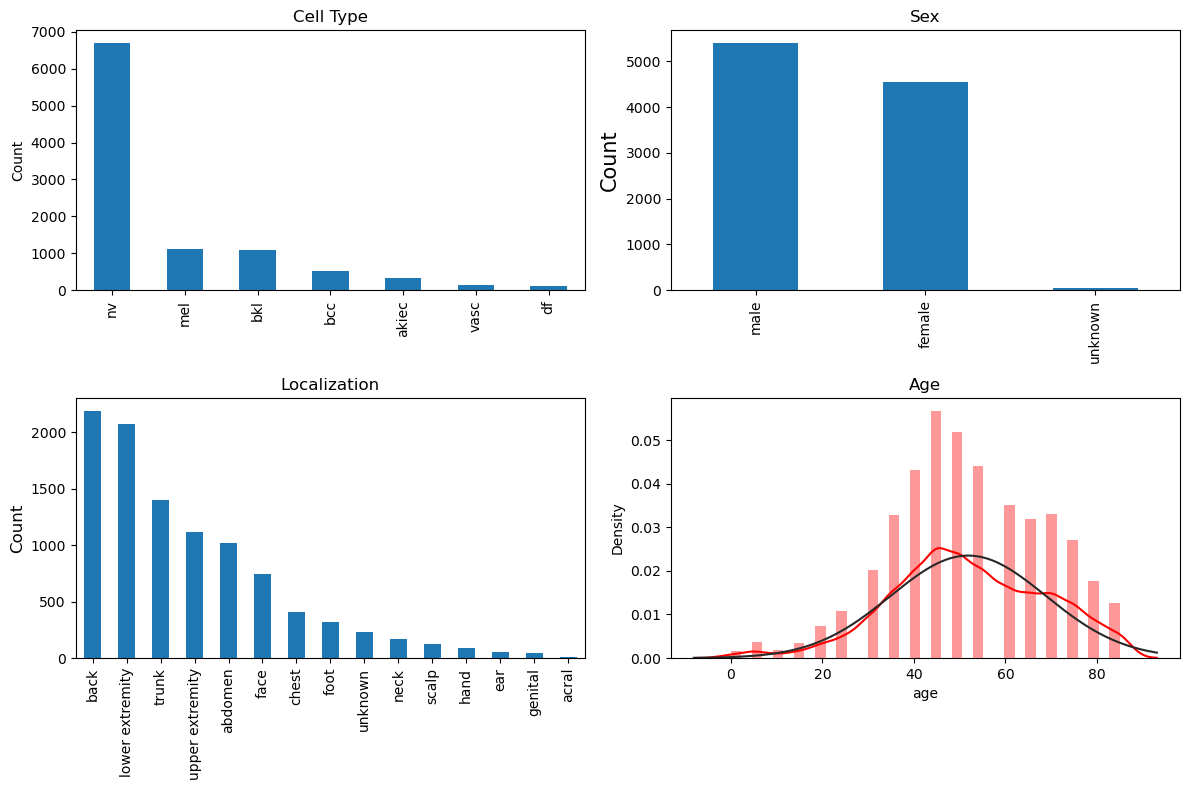

In [5]:
# Data distribution visualization
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()


In [6]:
# Distribution of data into various classes 
from sklearn.utils import resample
print(skin_df['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


In [7]:
df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

In [8]:
n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

In [9]:
#Combined back to a single dataframe
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

In [10]:
#Check the distribution. All classes should be balanced now.
print(skin_df_balanced['label'].value_counts())


0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: label, dtype: int64


In [11]:
#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('D:/cancer/', '*', '*.jpg'))}

In [13]:
#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)



In [14]:
skin_df_balanced

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path
9789,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,0,D:/cancer\HAM10000_images_part_1\ISIC_0026645.jpg
9957,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,0,D:/cancer\HAM10000_images_part_1\ISIC_0025780.jpg
9793,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,0,D:/cancer\HAM10000_images_part_1\ISIC_0024450.jpg
9758,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,0,D:/cancer\HAM10000_images_part_1\ISIC_0027896.jpg
9875,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,0,D:/cancer\HAM10000_images_part_1\ISIC_0029268.jpg
...,...,...,...,...,...,...,...,...,...
2375,HAM_0005989,ISIC_0033123,vasc,histo,25.0,female,back,6,D:/cancer\HAM10000_images_part_2\ISIC_0033123.jpg
2436,HAM_0004943,ISIC_0027790,vasc,consensus,50.0,female,face,6,D:/cancer\HAM10000_images_part_1\ISIC_0027790.jpg
2453,HAM_0001038,ISIC_0024706,vasc,consensus,50.0,male,trunk,6,D:/cancer\HAM10000_images_part_1\ISIC_0024706.jpg
2377,HAM_0007097,ISIC_0033762,vasc,histo,60.0,male,trunk,6,D:/cancer\HAM10000_images_part_2\ISIC_0033762.jpg


In [15]:
#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))


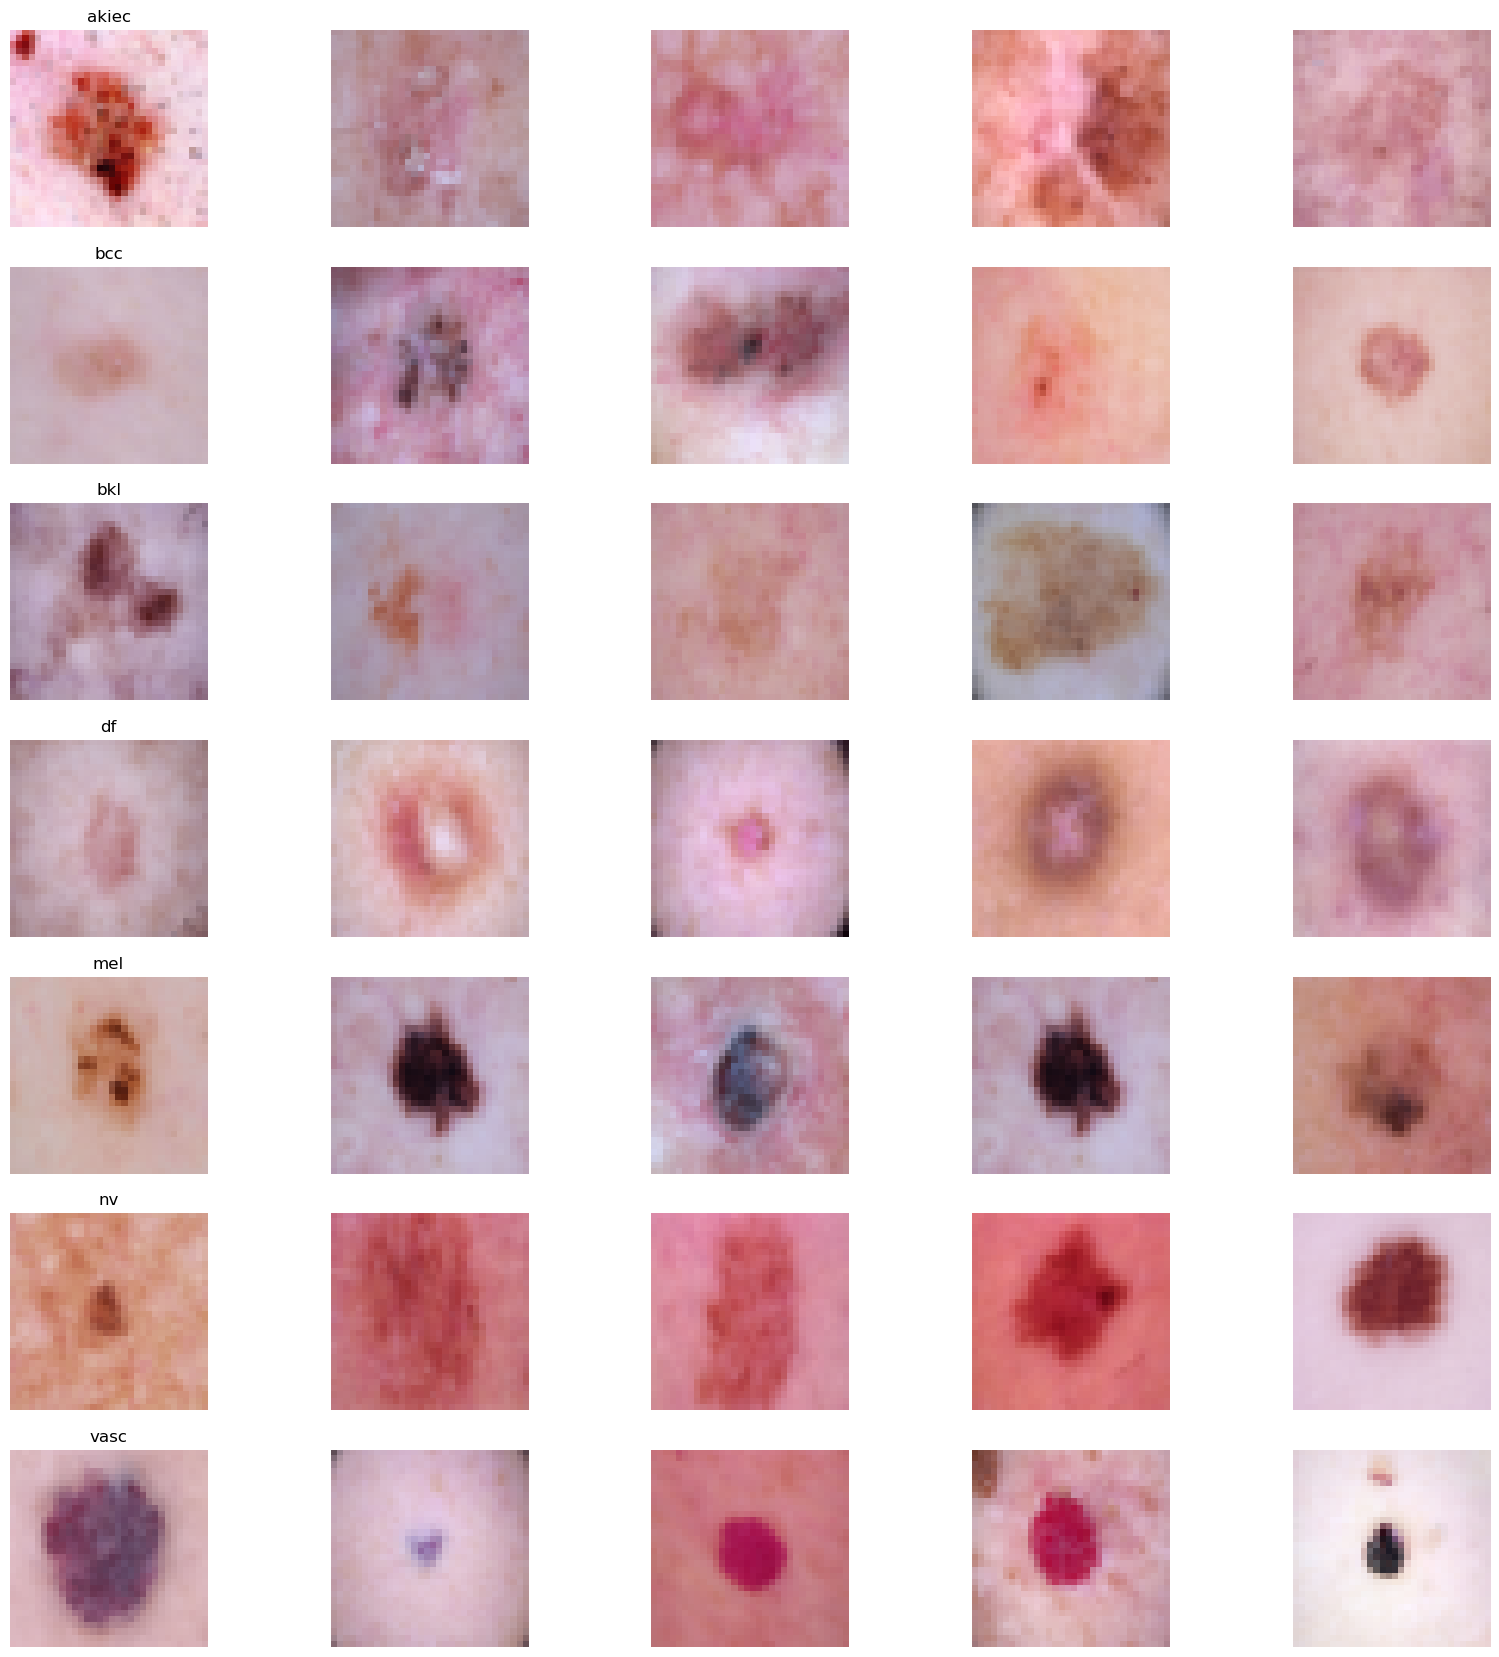

In [16]:
n_samples = 5  

# Plot
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')


In [17]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255. # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label'] #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem

In [18]:
#Split to training and testing. Get a very small dataset for training as we will be 
# fitting it to many potential models. 
x_train_auto, x_test_auto, y_train_auto, y_test_auto = train_test_split(X, Y_cat, test_size=0.95, random_state=42)


In [19]:
#Further split data into smaller size to get a small test dataset. 
x_unused, x_valid, y_unused, y_valid = train_test_split(x_test_auto, y_test_auto, test_size=0.05, random_state=42)


In [20]:
#Define classifier for autokeras. Here we check 25 different models, each model 25 epochs
clf = ak.ImageClassifier(max_trials=25) #MaxTrials - max. number of keras models to try
clf.fit(x_train_auto, y_train_auto, epochs=25)


Trial 25 Complete [00h 00m 18s]
val_loss: 1.1375330686569214

Best val_loss So Far: 0.9706283807754517
Total elapsed time: 01h 26m 58s
INFO:tensorflow:Oracle triggered exit
Epoch 1/25
6/6 [==============================] - 2s 71ms/step - loss: 2.0461 - accuracy: 0.1771
Epoch 2/25
6/6 [==============================] - 0s 59ms/step - loss: 1.6596 - accuracy: 0.3714
Epoch 3/25
6/6 [==============================] - 0s 63ms/step - loss: 1.5280 - accuracy: 0.4571
Epoch 4/25
6/6 [==============================] - 0s 59ms/step - loss: 1.3862 - accuracy: 0.5086
Epoch 5/25
6/6 [==============================] - 0s 60ms/step - loss: 1.2636 - accuracy: 0.5086
Epoch 6/25
6/6 [==============================] - 0s 66ms/step - loss: 1.1343 - accuracy: 0.5771
Epoch 7/25
6/6 [==============================] - 0s 63ms/step - loss: 1.0108 - accuracy: 0.6229
Epoch 8/25
6/6 [==============================] - 0s 67ms/step - loss: 0.9469 - accuracy: 0.6686
Epoch 9/25
6/6 [==============================] - 0

INFO:tensorflow:Assets written to: .\image_classifier\best_model\assets


INFO:tensorflow:Assets written to: .\image_classifier\best_model\assets


In [21]:
#Evaluate the classifier on test data
_, acc = clf.evaluate(x_valid, y_valid)
print("Accuracy = ", (acc * 100.0), "%")

6/6 [==============================] - 0s 13ms/step - loss: 2.7908 - accuracy: 0.4611
Accuracy =  46.107783913612366 %


In [22]:
# get the final best performing model
model = clf.export_model()
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 32, 32, 3)        0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 32, 32, 3)        7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0     

In [23]:
#Save the model
model.save('cifar_model.h5')

In [24]:
score = model.evaluate(x_valid, y_valid)
print('Test accuracy:', score[1])


6/6 [==============================] - 0s 16ms/step - loss: 2.7908 - accuracy: 0.4611
Test accuracy: 0.46107783913612366


In [25]:
num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 256)      0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 15, 15, 256)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 6, 6, 128)         0

In [27]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [28]:

# Train
#You can also use generator to use augmentation during training.

batch_size = 16 
epochs = 50

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

Epoch 1/50
165/165 - 21s - loss: 1.8699 - acc: 0.1970 - val_loss: 1.7621 - val_acc: 0.3109 - 21s/epoch - 129ms/step
Epoch 2/50
165/165 - 19s - loss: 1.6888 - acc: 0.2983 - val_loss: 1.5918 - val_acc: 0.3337 - 19s/epoch - 118ms/step
Epoch 3/50
165/165 - 20s - loss: 1.5236 - acc: 0.3676 - val_loss: 1.7426 - val_acc: 0.2754 - 20s/epoch - 121ms/step
Epoch 4/50
165/165 - 18s - loss: 1.4562 - acc: 0.4122 - val_loss: 1.5525 - val_acc: 0.3291 - 18s/epoch - 112ms/step
Epoch 5/50
165/165 - 18s - loss: 1.3858 - acc: 0.4518 - val_loss: 1.3567 - val_acc: 0.4480 - 18s/epoch - 110ms/step
Epoch 6/50
165/165 - 18s - loss: 1.3560 - acc: 0.4541 - val_loss: 1.3693 - val_acc: 0.4103 - 18s/epoch - 108ms/step
Epoch 7/50
165/165 - 18s - loss: 1.3413 - acc: 0.4686 - val_loss: 1.3824 - val_acc: 0.4549 - 18s/epoch - 109ms/step
Epoch 8/50
165/165 - 18s - loss: 1.2694 - acc: 0.4945 - val_loss: 1.2682 - val_acc: 0.4834 - 18s/epoch - 111ms/step
Epoch 9/50
165/165 - 18s - loss: 1.2506 - acc: 0.4983 - val_loss: 1.2223

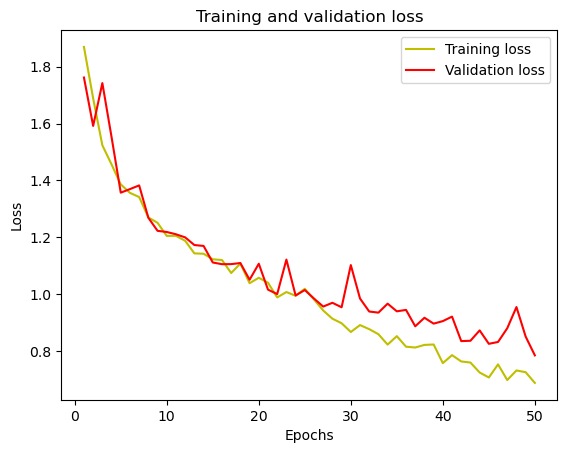

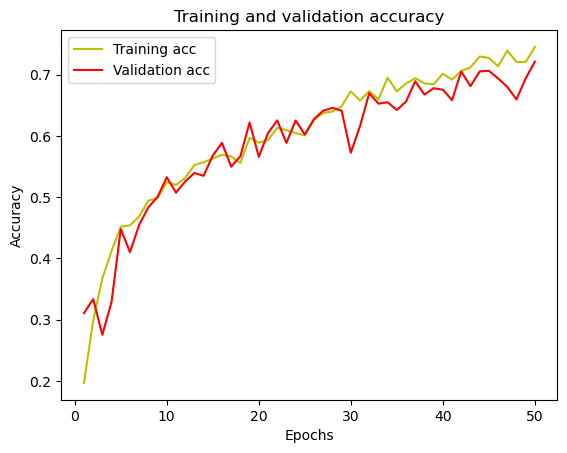

In [29]:

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [30]:

# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

28/28 [==============================] - 5s 44ms/step


<Axes: >

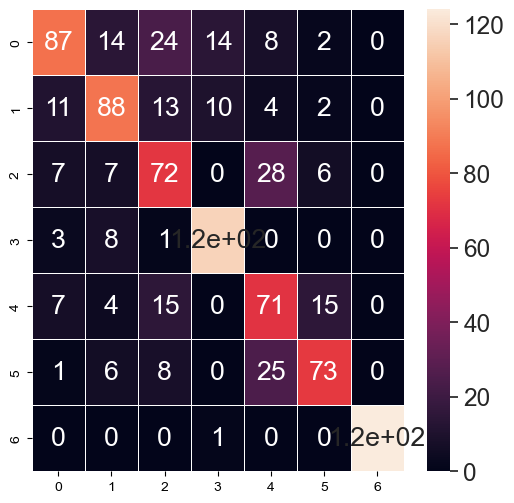

In [31]:
#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)


Text(0, 0.5, 'Fraction of incorrect predictions')

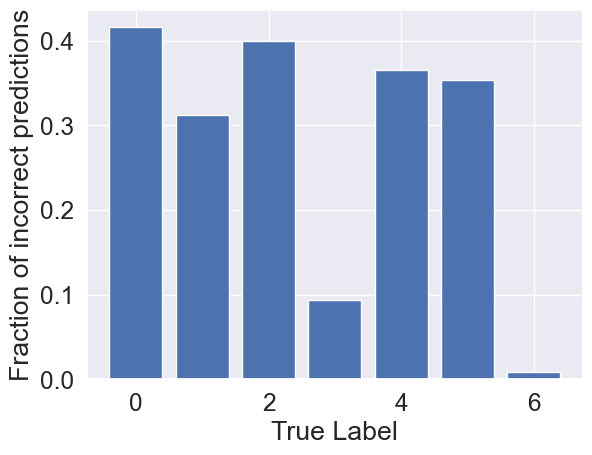

In [32]:

#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')


In [34]:
import pickle

In [35]:
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))